In [1]:
cd ..

C:\Users\688228hh\Kalman-Heston-Filter


In [2]:
from src.Utility import Utility, MeasurementType
from src.KalmanFilterCorr import HestonKalmanFilterCorr
# from src.QuasiLinearKalmanFilter import HestonKalmanFilterCorr
from src.ParticleFilter import PFHeston
from src.RealizedGARCH import RealizedGARCH
from src.Heston import *
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from typing import Dict, Optional, List, Any

In [3]:
def compute_standard_errors(model, epsilon: float = 1e-5) -> Dict[str, float]:
    """
    Compute standard errors for fitted Heston Kalman Filter parameters using numerical Hessian.
    
    Parameters:
    model : HestonKalmanFilterCorr
        Fitted Heston Kalman Filter model.
    epsilon : float, optional
        Step size for numerical differentiation. Default is 1e-5.
        
    Returns:
    Dict[str, float] : Dictionary with parameter names as keys and standard errors as values.
    """
    if model.params_dict is None:
        raise ValueError("Model must be fitted first. Call fit() method.")
    
    # Get parameter array from fitted model
    if model.measurement_type == MeasurementType.RETURNS:
        params = np.array([
            model.params_dict['kappa'], 
            model.params_dict['theta'], 
            model.params_dict['xi'], 
            model.params_dict['mu'],
            model.params_dict['rho']
        ])
        param_names = ['kappa', 'theta', 'xi', 'mu', 'rho']
    else:  # MeasurementType.BOTH
        params = np.array([
            model.params_dict['kappa'], 
            model.params_dict['theta'], 
            model.params_dict['xi'], 
            model.params_dict['mu'], 
            model.params_dict['sigma'],
            model.params_dict['rho']
        ])
        param_names = ['kappa', 'theta', 'xi', 'mu', 'sigma', 'rho']
    
    try:
        # Compute numerical Hessian
        n = len(params)
        hessian = np.zeros((n, n))
        f0 = model.negative_log_likelihood(params)
        
        for i in range(n):
            for j in range(i, n):
                if i == j:
                    # Diagonal elements using second-order central differences
                    params_p = params.copy()
                    params_m = params.copy()
                    params_p[i] += epsilon
                    params_m[i] -= epsilon
                    
                    f_p = model.negative_log_likelihood(params_p)
                    f_m = model.negative_log_likelihood(params_m)
                    
                    hessian[i, j] = (f_p - 2*f0 + f_m) / (epsilon**2)
                else:
                    # Off-diagonal elements using mixed partial derivatives
                    params_pp = params.copy()
                    params_pm = params.copy()
                    params_mp = params.copy()
                    params_mm = params.copy()
                    
                    params_pp[i] += epsilon
                    params_pp[j] += epsilon
                    
                    params_pm[i] += epsilon
                    params_pm[j] -= epsilon
                    
                    params_mp[i] -= epsilon
                    params_mp[j] += epsilon
                    
                    params_mm[i] -= epsilon
                    params_mm[j] -= epsilon
                    
                    f_pp = model.negative_log_likelihood(params_pp)
                    f_pm = model.negative_log_likelihood(params_pm)
                    f_mp = model.negative_log_likelihood(params_mp)
                    f_mm = model.negative_log_likelihood(params_mm)
                    
                    hessian[i, j] = (f_pp - f_pm - f_mp + f_mm) / (4 * epsilon**2)
                    hessian[j, i] = hessian[i, j]  # Symmetry
        
        # Compute inverse Hessian (covariance matrix)
        hessian_inv = np.linalg.inv(hessian)
        
        # Standard errors are square roots of diagonal elements
        se_values = np.sqrt(np.diag(hessian_inv))
        
        # Create dictionary with parameter names
        se_dict = dict(zip(param_names, se_values))
        
        # Store inverse Hessian in model for potential future use
        model.hessian_inv = hessian_inv
        
        return se_dict
        
    except np.linalg.LinAlgError:
        print("Warning: Could not compute standard errors due to singular Hessian matrix.")
        return dict(zip(param_names, [np.nan] * len(param_names)))
    except Exception as e:
        print(f"Error computing standard errors: {str(e)}")
        return dict(zip(param_names, [np.nan] * len(param_names)))

In [4]:
# Set initial conditions and simulation parameters
S0 = 100
V0 = 0.04
params = {
    'mu': 0.05,
    'rho': -0.8,
    'kappa': 5.0,
    'theta': 0.04,
    'xi': 0.35
}
std_asy = np.sqrt(params['theta'] * params['xi']**2 / (2 * params['kappa']))
feller_cond = 2 * params['kappa'] * params['theta'] / params['xi']**2
print(round(feller_cond, 2))
assert feller_cond > 1, "Feller condition is violated!"

Hest = Heston(**params)
time_daily, S_daily, daily_returns, daily_true_V, daily_RV = Hest.path_simulation(
    S0, V0, T_years=10, trading_days=252, intraday_intervals=39, seed=40
)
R_daily = daily_returns.copy()

3.27


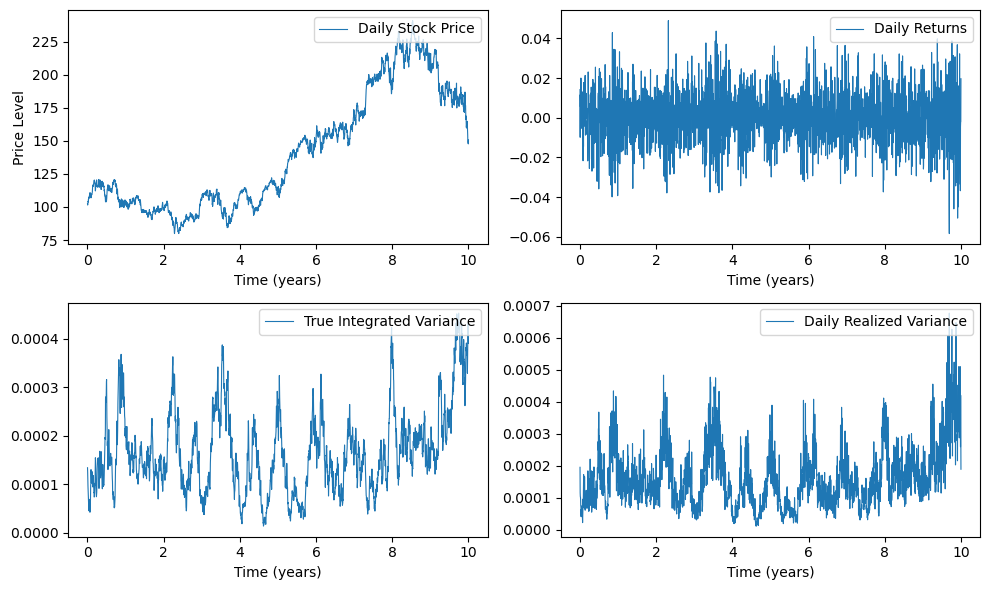

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Subplot for BOTH measurements
axes[0,0].plot(time_daily, S_daily, label="Daily Stock Price", lw=0.8)
axes[0,0].set_xlabel("Time (years)")
axes[0,0].set_ylabel("Price Level")
axes[0,0].legend(loc="upper right")

# Subplot for RETURNS measurement
axes[0,1].plot(time_daily, daily_returns, label="Daily Returns", lw=0.8)
axes[0,1].set_xlabel("Time (years)")
axes[0,1].legend(loc="upper right")

# Subplot for RV measurement
axes[1,0].plot(time_daily, daily_true_V, label="True Integrated Variance", lw=0.8)
axes[1,0].set_xlabel("Time (years)")
axes[1,0].legend(loc="upper right")

# Subplot for RV measurement
axes[1,1].plot(time_daily, daily_RV, label="Daily Realized Variance", lw=0.8)
axes[1,1].set_xlabel("Time (years)")
axes[1,1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [6]:
burnin = 252
dt = 1  # Daily

split_index = 6 * 252 

# TRAINING SET 
train_returns = daily_returns[:split_index]
train_RV = daily_RV[:split_index]

# TEST SET 
test_returns = daily_returns[split_index:]
test_RV = daily_RV[split_index:]

### Both - Corr

In [7]:
hkf_both_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
hkf_both_corr.set_data(returns=train_returns, rv=train_RV)
initial_params_both_corr = np.array([0.02, 0.00015, 0.001, 0.001, 0.001, -0.4]) # kappa, theta, xi, mu, sigma, rho

fit_results_both_corr = hkf_both_corr.fit(initial_params=initial_params_both_corr, burnin=burnin)
params_opt_both_corr = fit_results_both_corr['params']
print("Optimized parameters (BOTH):", params_opt_both_corr)

train_result_both_corr = hkf_both_corr.filter(params_opt_both_corr)
last_V_train_corr = train_result_both_corr['V_filt'][-1]
last_P_train_corr = train_result_both_corr['P_filt'][-1]

hkf_both_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train_corr, P0=last_P_train_corr)
test_result_both_corr = hkf_both_test_corr.filter(params=params_opt_both_corr, returns=test_returns, rv=test_RV)


QMLE Results for Heston Model:
--------------------------------------------------
kappa: 0.019949
theta: 0.000115
xi: 0.000238
mu: 0.000463
sigma: 0.000988
rho: -0.401621
Negative Log-Likelihood: -14131.149564
Convergence: True
--------------------------------------------------
Optimized parameters (BOTH): [ 1.99486470e-02  1.14929788e-04  2.37732140e-04  4.62742285e-04
  9.88319219e-04 -4.01620571e-01]


### Return - Corr

In [8]:
# Fit the model using training data
hkf_returns_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.02, P0=0.1)
hkf_returns_corr.set_data(returns=train_returns)
initial_params_returns_corr = np.array([0.02, 0.00015, 0.00138, 0.0002, -0.5]) # kappa, theta, xi, mu, rho

fit_results_returns_corr = hkf_returns_corr.fit(initial_params=initial_params_returns_corr, burnin=burnin)
params_opt_returns_corr = fit_results_returns_corr['params']
print("Optimized parameters (RETURNS):", params_opt_returns_corr)

train_result_returns_corr = hkf_returns_corr.filter(params_opt_returns_corr)
last_V_returns_corr = train_result_returns_corr['V_filt'][-1]
last_P_returns_corr = train_result_returns_corr['P_filt'][-1]

hkf_returns_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns_corr, P0=last_P_returns_corr)
test_result_returns_corr = hkf_returns_test_corr.filter(params=params_opt_returns_corr, returns=test_returns)


QMLE Results for Heston Model:
--------------------------------------------------
kappa: 0.024950
theta: 0.000146
xi: 0.002012
mu: 0.000380
rho: -0.499996
Negative Log-Likelihood: -3810.057665
Convergence: True
--------------------------------------------------
Optimized parameters (RETURNS): [ 2.49496028e-02  1.46448218e-04  2.01224446e-03  3.80412141e-04
 -4.99995641e-01]


### PF

In [9]:
pf_heston_train = PFHeston(train_returns, N=10000, dt=1/252, is_log=True)

param_bounds_train = [
    (-0.1, 0.1),    # mu
    (1, 5),        # kappa
    (0.02, 0.03),    # theta
    (0.1, 0.3),    # xi
    (-0.9, 0),        # rho
    V0              # v0
]

_, estimated_param = pf_heston_train.filter(param_bounds_train, predict_obs=False)
param_bounds = list(zip(estimated_param[:,-1] - 1e-3, estimated_param[:,-1] + 1e-3))

resampling since: 609.198986143345
resampling since: 1583.7702889995314
resampling since: 4489.732057487852
resampling since: 2508.938993334179
resampling since: 1200.6690043406786
resampling since: 1684.9228517920112
resampling since: 5099.408923531529
resampling since: 5477.729684497965
resampling since: 6403.4667086536465
resampling since: 6173.93943695686
resampling since: 1286.892121545683
resampling since: 3328.6262081726322
resampling since: 4925.718265602068
resampling since: 2071.0230702224912
resampling since: 1222.6569035606142
resampling since: 6277.918987391175
resampling since: 3880.827970255045
resampling since: 2044.9497417088235
resampling since: 4428.6695428300045
resampling since: 547.393022900345
resampling since: 2380.180384790893
resampling since: 5213.2966827035925
resampling since: 2636.4727012199896
resampling since: 3301.4526849450904
resampling since: 2229.6788859202325
resampling since: 1759.5561401345692
resampling since: 1128.7552295211565
resampling since

In [10]:
pf_heston_test = PFHeston(test_returns, N=10000, dt=1/252, is_log=True)

V_pf_train, _ = pf_heston_train.filter([*param_bounds, V0], predict_obs=False)
V_pf_test, _ = pf_heston_test.filter([*param_bounds, V_pf_train[-1]], predict_obs=False)

resampling since: 6278.605950849678
resampling since: 6217.843752750149
resampling since: 6697.178825596562
resampling since: 6064.905820261787
resampling since: 5380.876784300306
resampling since: 6364.93901641965
resampling since: 6329.102008301996
resampling since: 6896.2497245586155
resampling since: 6505.642527666781
resampling since: 6411.61849109472
resampling since: 6811.238851890712
resampling since: 4369.308944910544
resampling since: 6465.948597626615
resampling since: 6812.525673284857
resampling since: 6961.052867703499
resampling since: 6455.581019273436
resampling since: 6452.301376824207
resampling since: 3067.458833958355
resampling since: 5204.195796981221
resampling since: 6698.625014337535
resampling since: 6926.893946054901
resampling since: 3220.439406937557
resampling since: 6645.679679583906
resampling since: 6736.622155484399
resampling since: 6867.5660879889465
resampling since: 6988.814957964856
resampling since: 4852.474685028999
resampling since: 5971.11023

In [11]:
V_pf_train_daily = V_pf_train / 400
V_pf_test_daily = V_pf_test / 400

### Realized GARCH

In [12]:
# Fit the model
model = RealizedGARCH(p=1, q=1)
model.fit(train_returns, train_RV)

# Get fitted volatility (in-sample)
fitted_vol = model.get_fitted_volatility(train_returns, train_RV)

# Predict volatility (out-of-sample)
predicted_vol = model.predict(test_returns, test_RV)

## Plot

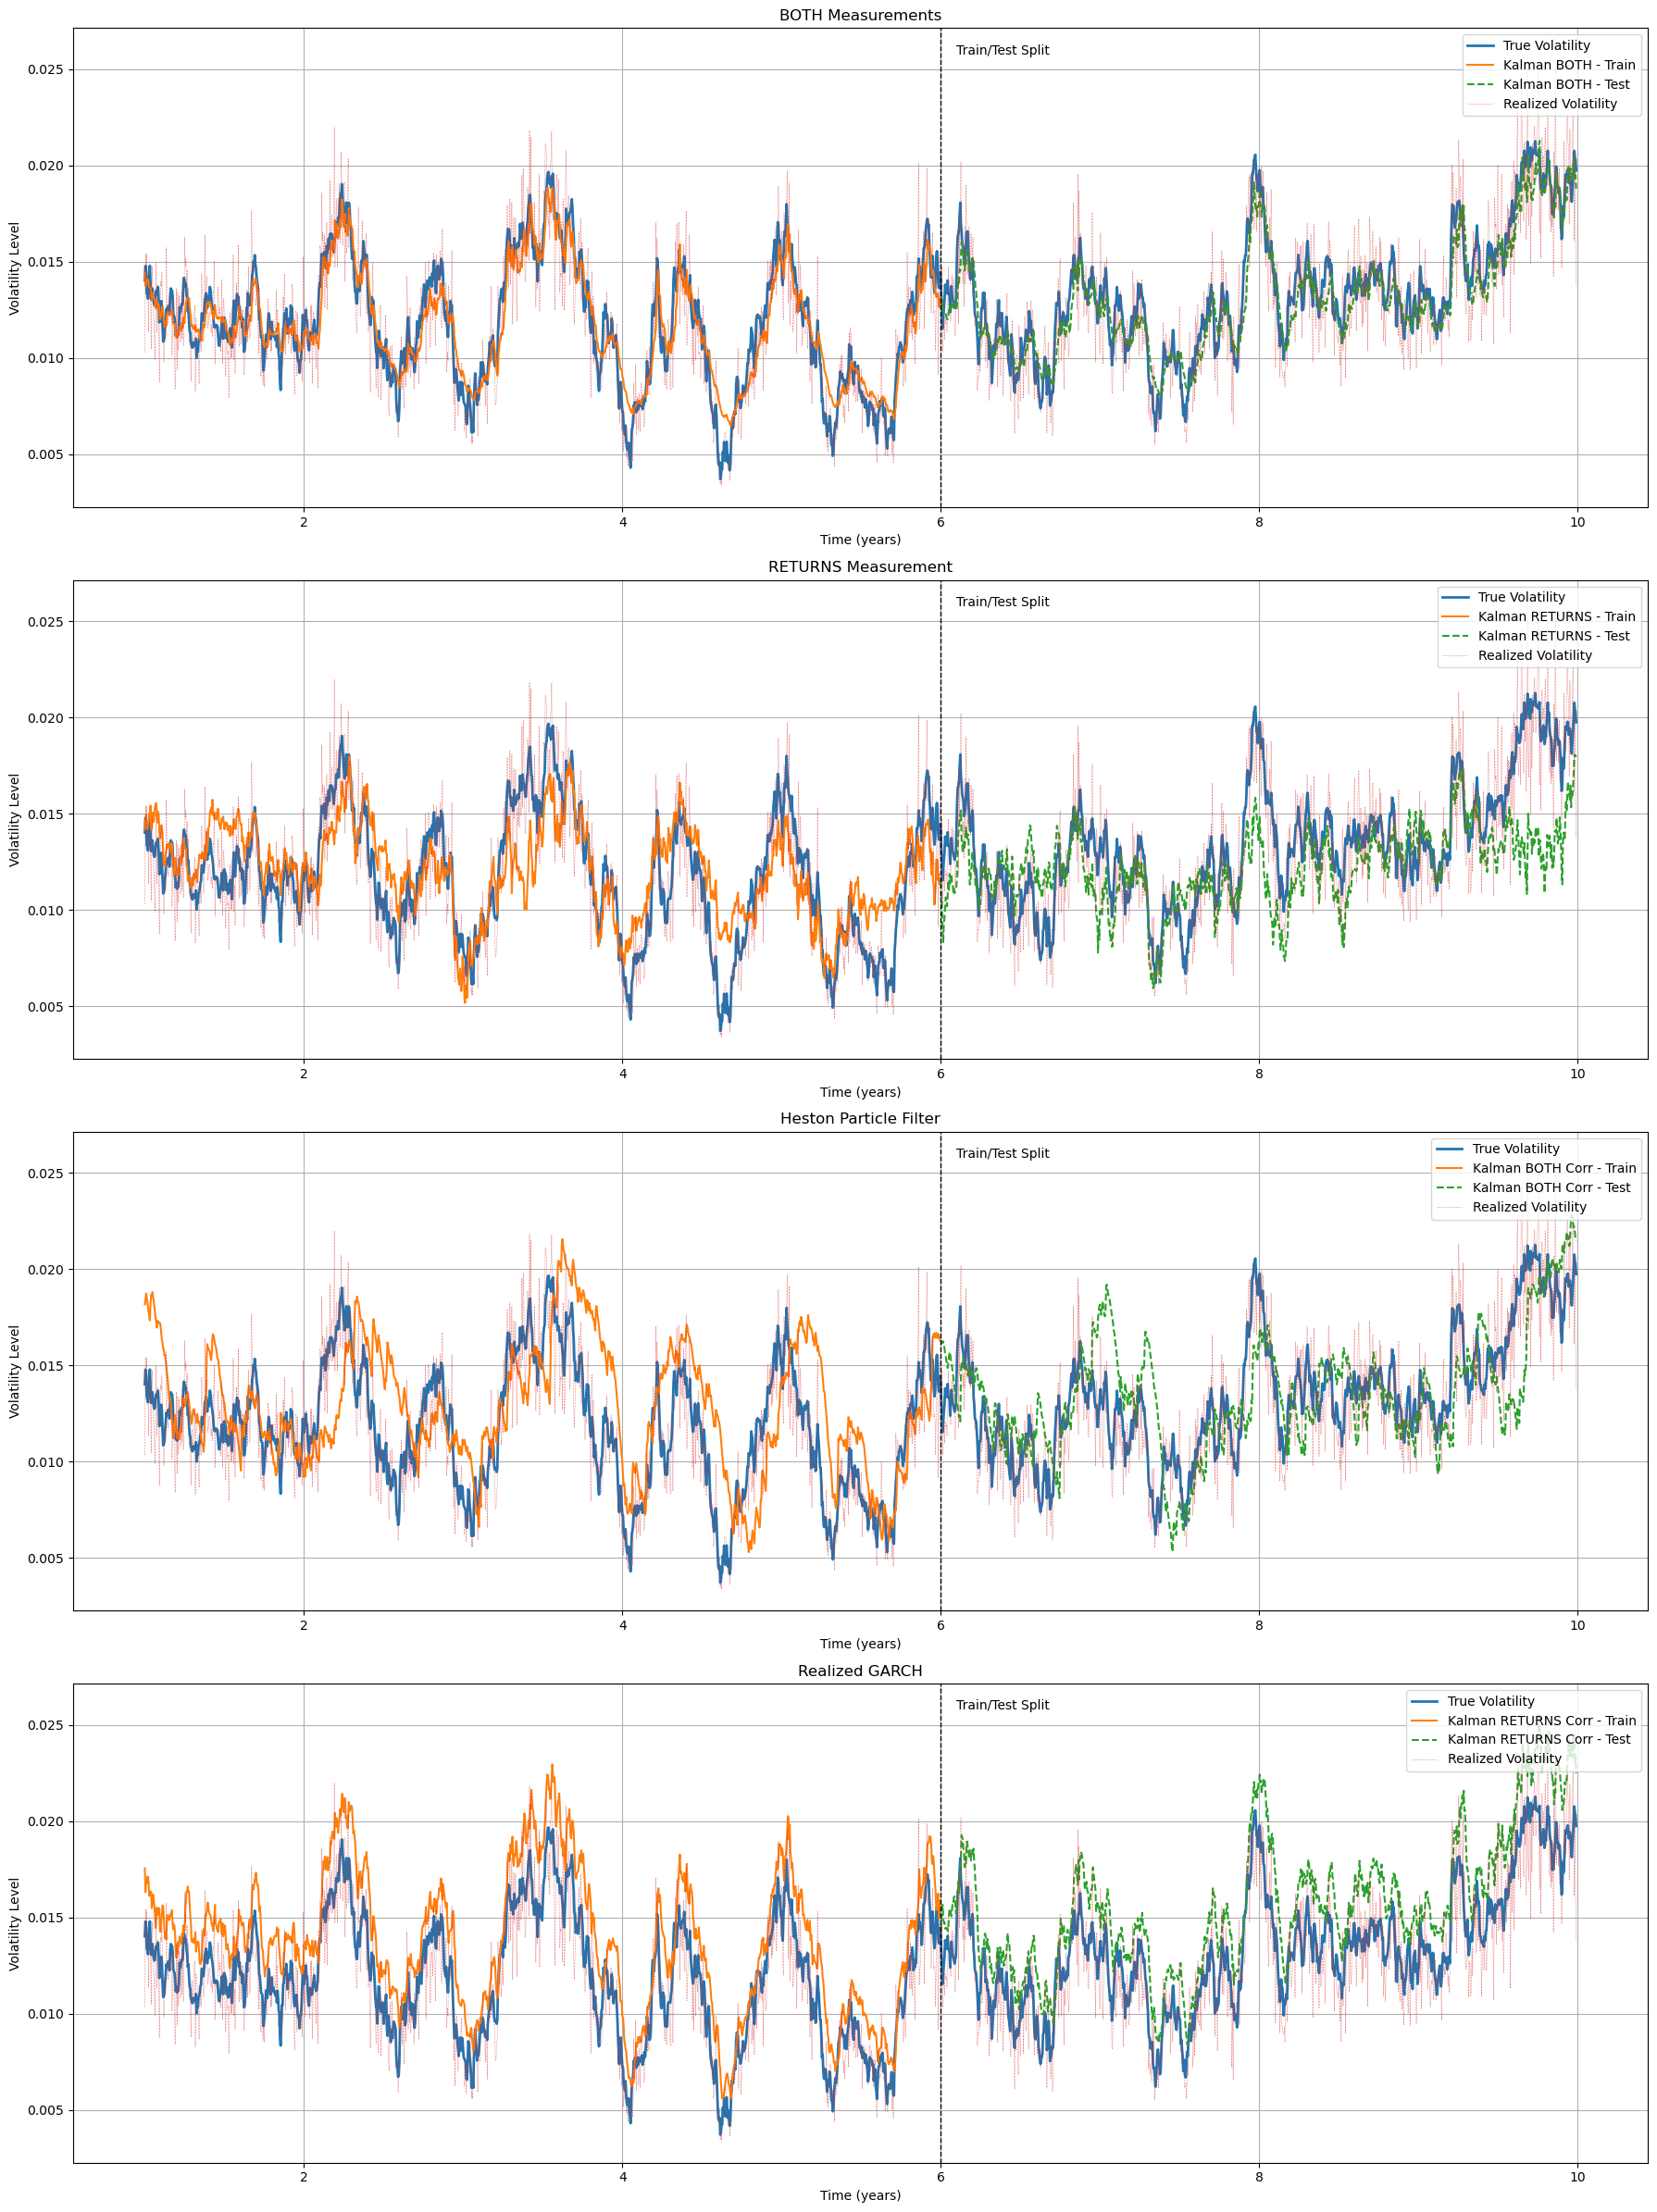

In [13]:
v_item = 'V_pred'

titles_all = ["BOTH Measurements", "RETURNS Measurement", "Heston Particle Filter", "Realized GARCH"]
labels_all = ["Kalman BOTH", "Kalman RETURNS", "Kalman BOTH Corr", "Kalman RETURNS Corr", "PF Heston", "Realized GARCH"]
train_all = [train_result_both_corr[v_item], train_result_returns_corr[v_item], V_pf_train_daily, fitted_vol]
test_all = [test_result_both_corr[v_item], test_result_returns_corr[v_item], V_pf_test_daily, predicted_vol]

Utility.plot_all_filters(
    titles=titles_all,
    labels=labels_all,
    train_filtered_list=train_all,
    test_filtered_list=test_all,
    daily_true_V=daily_true_V,
    daily_RV=daily_RV,
    daily_returns=daily_returns,
    split_index=split_index,
    burnin=252, 
    save_path=r"./output/base.png"
)

In [22]:
def qlike_loss(true_var, pred_var):
    y = np.asarray(true_var)
    h = np.asarray(pred_var)
    
    eps = np.finfo(float).eps
    ratio = y / (h + eps)
    return np.mean(ratio - np.log(ratio) - 1)

model_names = ['RV-QLKF', 'QLKF', 'PF', 'Realized GARCH']
true_variances   = daily_true_V[split_index:]
true_volatilities = np.sqrt(true_variances)

mae_scores   = {}
rmse_scores  = {}
qlike_scores = {}

for name, pred_var in zip(model_names, np.array(test_all).clip(1e-9, None)):
    pred_vol = np.sqrt(pred_var)
    
    mae_scores[name]   = mean_absolute_error(true_volatilities, pred_vol)
    rmse_scores[name]  = np.sqrt(mean_squared_error(true_volatilities, pred_vol))
    qlike_scores[name] = qlike_loss(true_variances, pred_var)

print("Results:")
for name in model_names:
    print(f"{name:18s} RMSE: {rmse_scores[name]:.6f}, "
          f"QLIKE: {qlike_scores[name]:.6f}")

Results:
RV-QLKF            RMSE: 0.001094, QLIKE: 0.015483
QLKF               RMSE: 0.002658, QLIKE: 0.091139
PF                 RMSE: 0.002641, QLIKE: 0.085498
Realized GARCH     RMSE: 0.002607, QLIKE: 0.056276


In [15]:
standard_errors = compute_standard_errors(hkf_both_corr)
print("Standard Errors:", standard_errors)

Standard Errors: {'kappa': 0.004378927781687224, 'theta': 1.8739570397991384e-05, 'xi': nan, 'mu': 0.0003019882719348305, 'sigma': 0.00012469830749874998, 'rho': 0.04377299075589685}


In [16]:
data = {}

data['RV-QLKF'] = dict(zip(
    ['kappa', 'theta', 'xi', 'mu', 'sigma', 'rho'],
    [*(params_opt_both_corr[:-1] * 252), params_opt_both_corr[-1]]
))

data['QLKF'] = dict(zip(
    ['kappa', 'theta', 'xi', 'mu', 'rho'],
    [*(params_opt_returns_corr[:-1] * 252), params_opt_returns_corr[-1]]
))
data['QLKF']['sigma'] = np.nan

pf_vals = estimated_param[:, -1]
data['PF'] = {
    'kappa': pf_vals[1],
    'theta': pf_vals[2],
    'xi':    pf_vals[3],
    'mu':    pf_vals[0],
    'rho':   pf_vals[4],
    'sigma': np.nan
}

cols = ['kappa', 'theta', 'xi', 'mu', 'sigma', 'rho']
df_params = pd.DataFrame.from_dict(data, orient='index')[cols]

df_params.T

,RV-QLKF,QLKF,PF
kappa,5.027059,6.287300,1.291022
theta,0.028962,0.036905,0.027551
xi,0.059908,0.507086,0.280506
mu,0.116611,0.095864,0.041478
sigma,0.249056,NaN,NaN
rho,-0.401621,-0.499996,-0.228878


In [17]:
pd.Series(dict(zip(model.param_names[:-1], np.round(model.params[:-1], 3))))

omega      0.009
beta       0.781
gamma      0.210
xi        -0.502
phi        0.935
tau_1      0.075
tau_2      0.006
sigma_u    0.240
dtype: float64

In [19]:
from model_confidence_set import ModelConfidenceSet


# Example losses matrix where rows are observations and columns are models
losses = np.random.rand(100, 5)  # 100 observations for 5 models

# Initialize the MCS procedure (5'000 bootstrap iterations, 5% confidence level)
mcs = ModelConfidenceSet(losses, n_boot=5000, alpha=0.05, show_progress=True)

# Compute the MCS
mcs.compute()

# Retrieve the results as a pandas DataFrame (use as_dataframe=False for a dict)
results = mcs.results()

Computing MCS: 100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 998.23model/s]


In [20]:
results

,pvalues,status
models,,
3,0.1464,included
5,0.1772,included
2,0.5414,included
1,0.5414,included
4,1.0000,included
